# Fetal Immune Atlas - Uniforming cell labels

In [68]:
import os,sys
import scanpy as sc 
import anndata
import numpy as np
import pandas as pd
import re

In [122]:
%load_ext rpy2.ipython

### Load annotations

In [103]:
annot_dir = '/nfs/team205/ed6/data/Fetal_immune/annotations_20201222/'

lvls_annot_files = [x for x in os.listdir(annot_dir) if "annot_lvls" in x]
organs = [x.split("_annot")[0] for x in lvls_annot_files]

In [133]:
cell_labels_full = pd.DataFrame()
for organ,file in zip(organs, lvls_annot_files):
    ## Read labels translations
    new_labels = pd.read_csv(annot_dir + file, index_col=0)

    ## Read labels file
    labels_file = [x for x in os.listdir(annot_dir) if re.match(file.split("_lvls")[0] + '_.+20.csv', x)][0]
    orig_labels_df = pd.read_csv(annot_dir + labels_file,  index_col=0)

    ## Add updated labels
    orig_labels_df['updated_cell_type'] = new_labels.loc[orig_labels_df["cell.labels"]]['updated_cell_type'].values
    orig_labels_df["organ"] = organ
    cell_labels_full = pd.concat([cell_labels_full, orig_labels_df], 0)

In [144]:
labels_count = cell_labels_full.reset_index()[["updated_cell_type", "organ", "index"]].groupby(["updated_cell_type", "organ"]).count().reset_index()
labels_count.columns = ["updated_cell_type", "organ", "n_cells"]

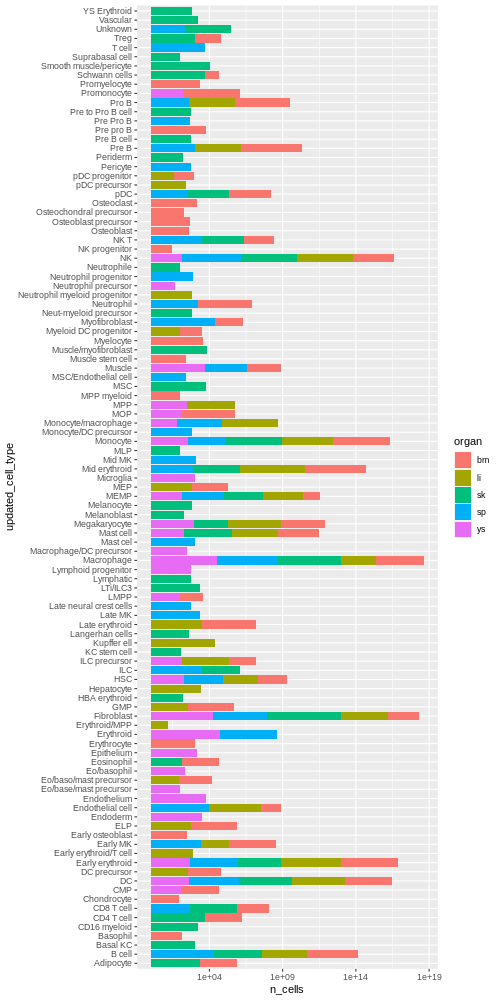

In [151]:
%%R -i labels_count -h 1000 -w 500
library(ggplot2)
library(dplyr)

labels_count %>%
ggplot(aes(updated_cell_type, n_cells, fill=organ)) +
geom_col() +
scale_y_log10() +
coord_flip()


Some notes:

* translate "Pre pro B" to "Pre Pro B"
* Eo/base/mast precursor
* difference between Pro B and Pre B?
* Should YS Erythroid stay separate from Erythroid?
* Endothelium VS endothelial cell

In [155]:
np.unique([x for x in cell_labels_full.updated_cell_type if "Endo" in x])

array(['Endoderm', 'Endothelial cell', 'Endothelium',
       'MSC/Endothelial cell'], dtype='<U20')